#### Research Notebook: Evaluation of Privacy-Preserving Machine Learning with FHE

This research notebook will evaluate different models performance by comparing the classical models, provided by the scikit-learn library (which uses plain text data) to the equivalent provided by the concrete-ml models which works by leveragin the Fully Homomorphic Encryption. Specifically, the comparison will consider the following aspects (plaintext vs ciphertext):
- Overall Accuracy of the plaintext
- Latency of the model in plaintext     (average inference time on 100 iterations)
- Accuracy of the model in ciphertext giving from the training from scratch with a varying bid-width (sort of hyper-parameter tuning)
- Latency of the cipher model (average inference time on 100 iterations) varying the bid-width


### Configuration of the Environment

In [ ]:
%pip install concrete-ml
%pip install kagglehub[pandas-datasets]
%pip install kagglehub
%pip install seaborn
%pip install imblearn

In [99]:
# data preprocessing
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# data manipulation
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# models
from sklearn.model_selection import StratifiedKFold
from pandas import pandas as pd # needed to handle csv files
from concrete.ml.sklearn import LogisticRegression
# plain models
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# cipher models
from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDecisionTreeClassifier




### About the Dataset: Credit Fraud Detection

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
It is available on Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download) and it is used under the Database Contents License (DbCL) v1.0

### Data Preprocessing: Exploration

In [ ]:
df = pd.read_csv("creditcard.csv")

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Looking at the df.describe() outcome the following consideration about the dataset can be made:
1. **Time Feature**:
    - The `Time` feature represents the seconds elapsed between each transaction and the first transaction in the dataset.
    - The range of values indicates transactions span over a significant time period.

2. **Amount Feature**:
    - The `Amount` feature represents the transaction amount.
    - The mean and standard deviation suggest a wide variation in transaction amounts, with some outliers likely present.

3. **Principal Components (V1 to V28)**:
    - These features are the result of PCA transformation and are scaled.
    - The mean values are close to zero, and the standard deviations indicate the spread of the data.

4. **Class Feature**:
    - The `Class` feature is the target variable, where `1` indicates fraud and `0` indicates non-fraud.
    - The dataset is highly imbalanced, as observed in the count of fraudulent vs. non-fraudulent transactions.

```

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Missing value evaluation

In [ ]:
if df.isnull().sum().sum() > 0: # the value will be higher than one if there is at least one missing value
    print("There are missing values")
else:
    print("This dataset does not contain any missing values")

This dataset does not contain any missing values


#### Class Distribution evaluation


As expected the classes are highly imbalanced, thus rebalancing is needed to perform good model training

In [ ]:
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

#### Correlation Analysis

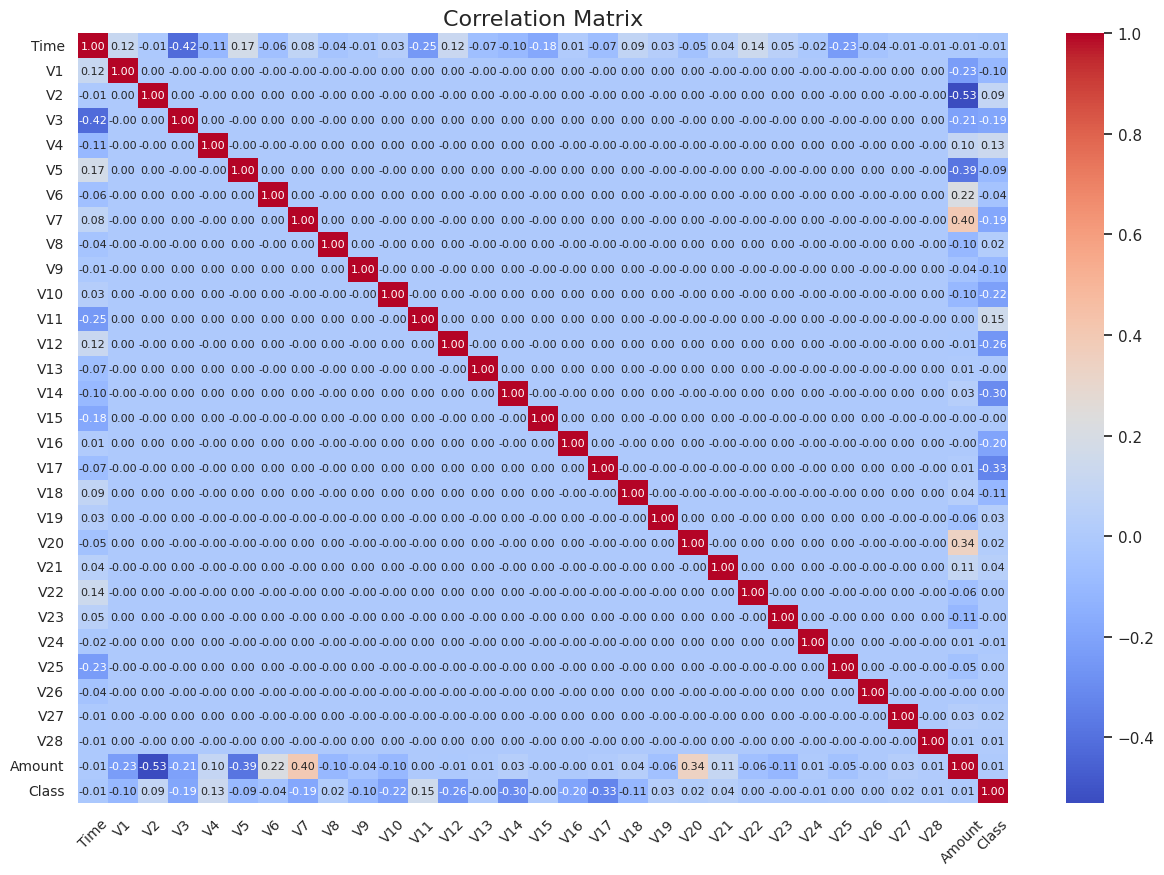

In [ ]:
correlation_matrix = df.corr()

plt.figure(figsize=(15, 10))  
heatmap = sn.heatmap(
    data=correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    annot_kws={"size": 8}  
)
plt.title("Correlation Matrix", fontsize=16)  
plt.xticks(fontsize=10, rotation=45)  
plt.yticks(fontsize=10)
plt.show()

#### Data Distribution and Scaling

<Axes: >

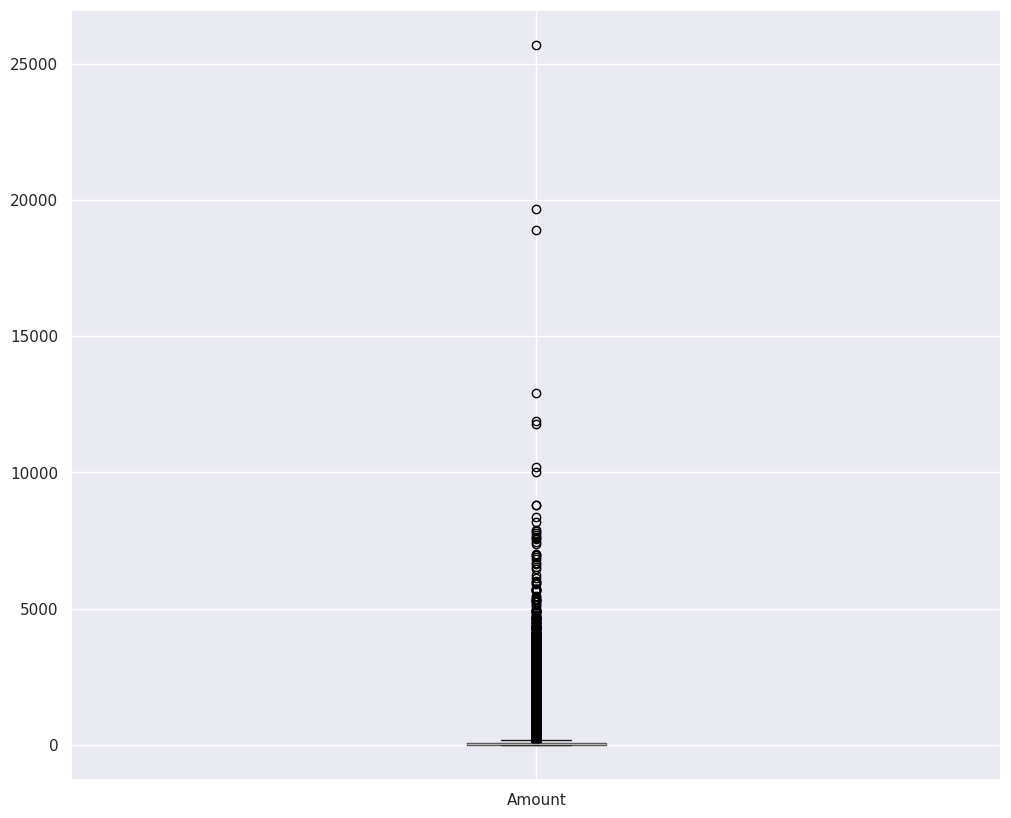

In [ ]:
df.boxplot(column=['Amount'])

<Axes: >

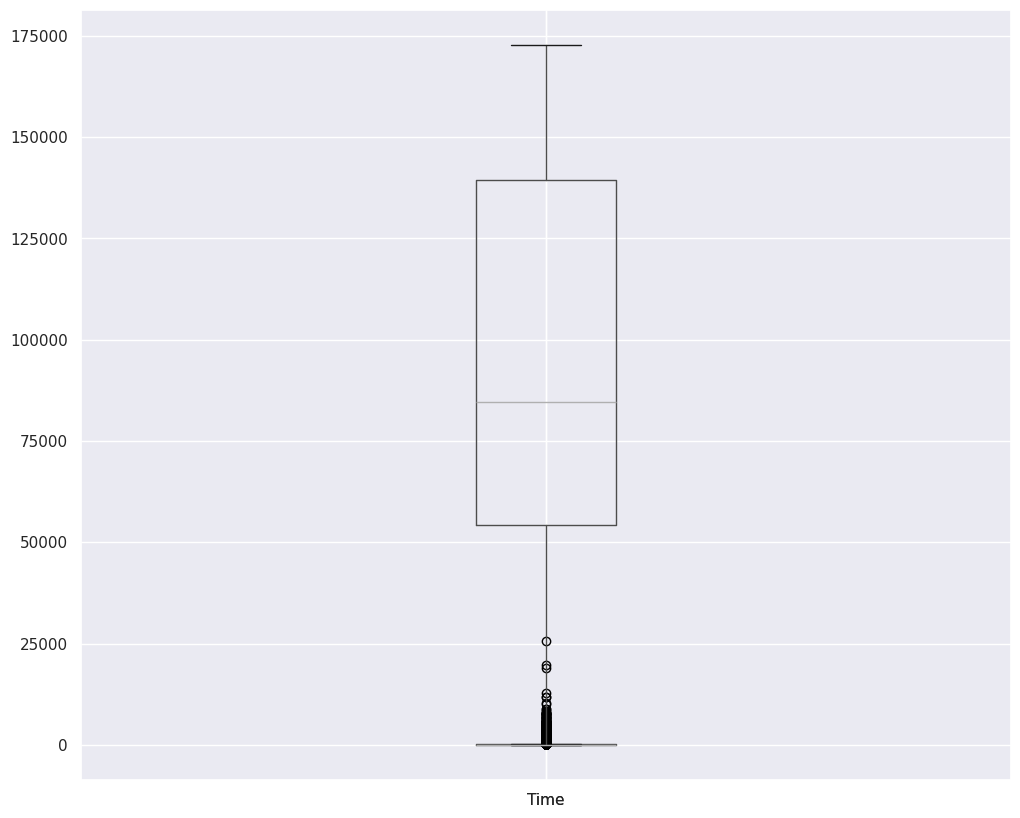

In [ ]:
df.boxplot(column=['Time'])

##### Class Imbalance Handling

Given the highly imbalanced nature of the dataset (fraudulent transactions accounting for only 0.172%), undersampling was chosen to reduce computational costs and training time while maintaining focus on the minority class. The large dataset size (284,807 samples) ensures sufficient data remains for training, even after undersampling, without introducing synthetic data that could risk overfitting.


In [ ]:
undersampler = RandomUnderSampler(random_state=42)

In [ ]:
x = df.drop(columns=['Class']).values  # Features
y = df['Class'].values  # Target variable

#### Decision Tree Model : Plain

##### Hypeparameter Tuning

In [ ]:
# 10-Fold Cross Validation
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    
    X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)

    dt_model = DecisionTreeClassifier(random_state=42)

    grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled, Y_train_resampled)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)


Best Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}
Best Score: 0.9298679919450563
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.75, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Best Score: 0.9195384594574056
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 20, 'splitter': 'random'}
Best Score: 0.9252262872298896


Building of the final model

In [ ]:
# {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}
best_params = {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}

# best_params = grid_search.best_params_
# Initialize the final Decision Tree model with the best parameters
final_model = DecisionTreeClassifier(**best_params, random_state=42)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)

    final_model.fit(X_train_resampled, Y_train_resampled)
    score = final_model.score(X_test, Y_test)
    cv_scores.append(score)

average_accuracy = np.mean(cv_scores)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Average Cross-Validation Accuracy: {average_accuracy}")


Cross-Validation Accuracy Scores: [0.9434710859871493, 0.9587093149819178, 0.9536884238615218, 0.9536533127348057, 0.9138724061655139, 0.9360977493767775, 0.9184368526386012, 0.9692766853932584, 0.9378862359550562, 0.9364115168539325]
Average Cross-Validation Accuracy: 0.9421503583948534
Average Precision: 0.02807281499986246
Average Recall: 0.8840816326530613
Average F1 Score: 0.05427088063000263
Average AUC: 0.9457849459033387


#### Decision Tree Model : FHE

In [ ]:
# 10-Fold Stratified Cross Validation
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    
    # undersampling
    X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)

    dt_model = ConcreteDecisionTreeClassifier(random_state=42)

    grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled, Y_train_resampled)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

In [ ]:
# {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}
best_params = {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}

# best_params = grid_search.best_params_

final_model = ConcreteDecisionTreeClassifier(**best_params, random_state=42)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)

    final_model.fit(X_train_resampled, Y_train_resampled)
    score = final_model.score(X_test, Y_test)
    cv_scores.append(score)

average_accuracy = np.mean(cv_scores)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Average Cross-Validation Accuracy: {average_accuracy}")


Cross-Validation Accuracy Scores: [0.9704715424317967, 0.9484217548541133, 0.9511604227379656, 0.9439626417611742, 0.9589902039956463, 0.9283381903725291, 0.943857308381026, 0.9512991573033708, 0.9708918539325843, 0.9498946629213483]
Average Cross-Validation Accuracy: 0.9517287738691556
Average Precision: 0.03237763669612366
Average Recall: 0.8719591836734694
Average F1 Score: 0.0622738047062751
Average AUC: 0.9500269583258003
